<a href="https://colab.research.google.com/github/anshupandey/Computer-Vision/blob/master/image_segmentation/Image_Segmentation_with_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collecting data

In [1]:
!wget -q https://www.dropbox.com/s/ghvpyv3hbw67cpt/camvid.tar

In [2]:
!wget -q http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/label_colors.txt

In [3]:
!tar -xvf camvid.tar  > /dev/null; echo " done."

 done.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.preprocessing import image

# Data Exploration

In [31]:
image_dir = "/content/camvid/images/"
masks_dir = "/content/camvid/labels/"
image_list = os.listdir(image_dir)
mask_list = os.listdir(masks_dir)
print(image_list[:5])
print(mask_list[:5])

['0016E5_02220.png', 'Seq05VD_f04530.png', 'Seq05VD_f00870.png', 'Seq05VD_f01740.png', '0016E5_08061.png']
['0016E5_08019_P.png', '0006R0_f01920_P.png', '0016E5_07500_P.png', '0006R0_f02700_P.png', '0016E5_08127_P.png']


In [6]:
print(len(image_list))
print(len(mask_list))

702
701


In [32]:
!rm camvid/images/test.txt
image_list = os.listdir(image_dir)
mask_list = os.listdir(masks_dir)
print(len(image_list))
print(len(mask_list))

rm: cannot remove 'camvid/images/test.txt': No such file or directory
701
701


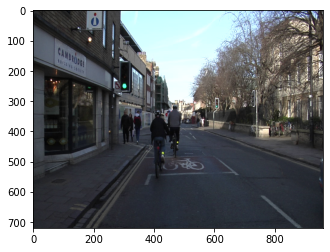

In [8]:
plt.imshow(plt.imread(image_dir+image_list[4]))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


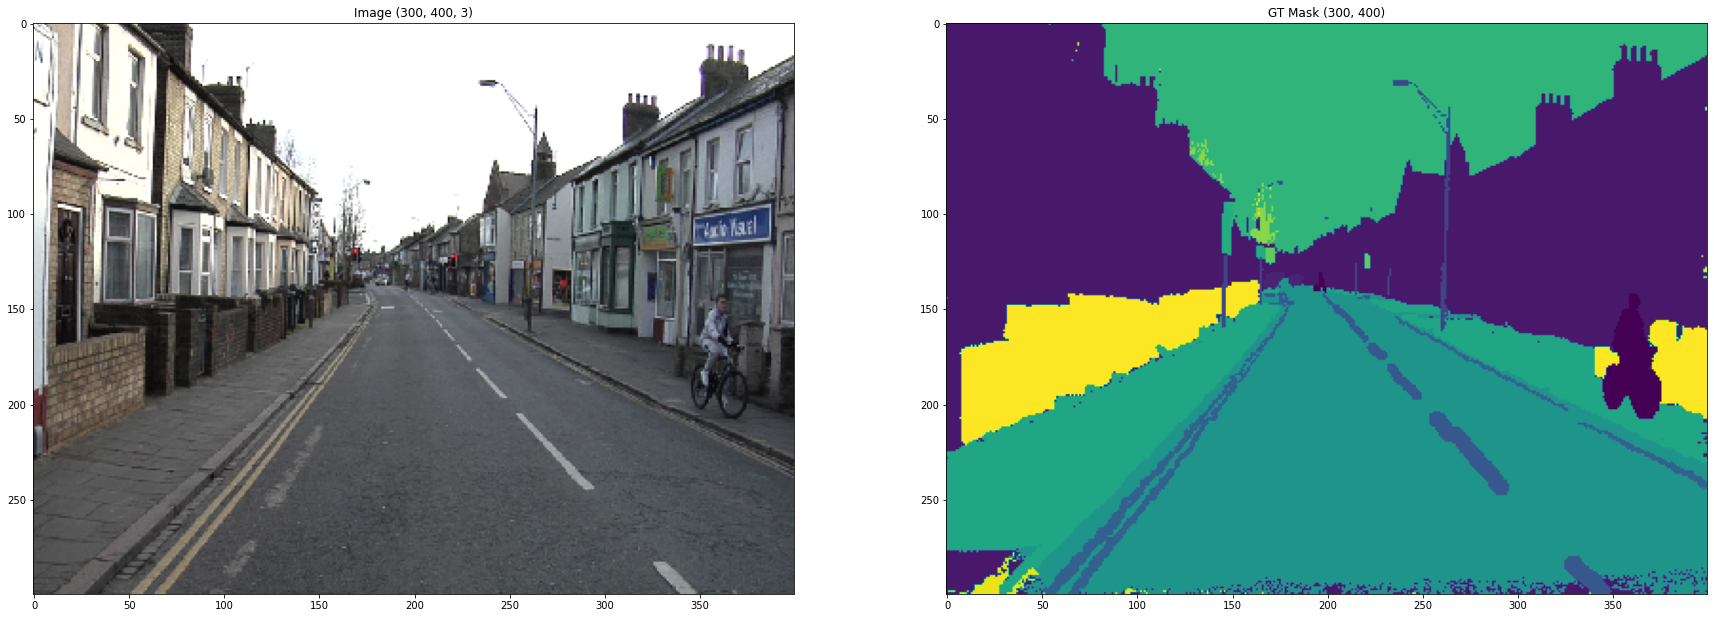

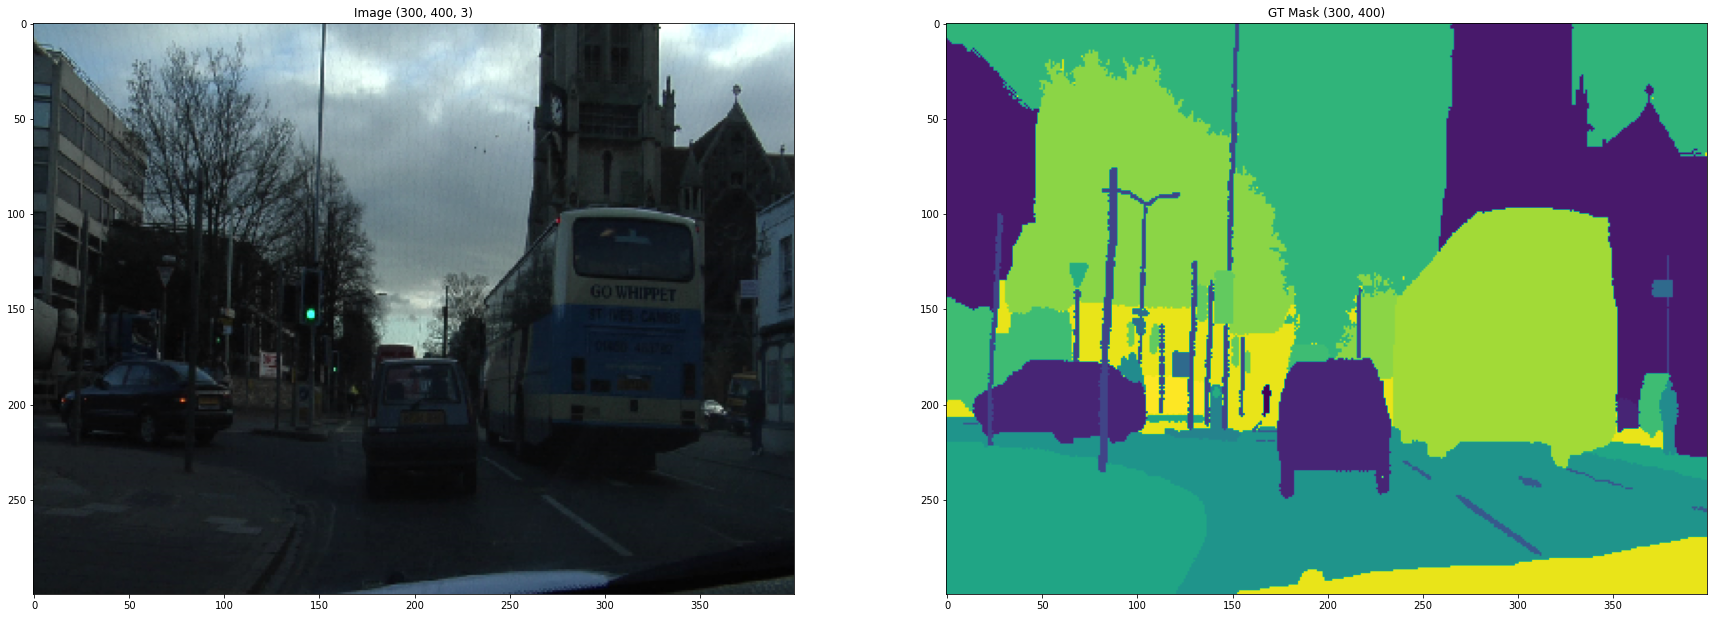

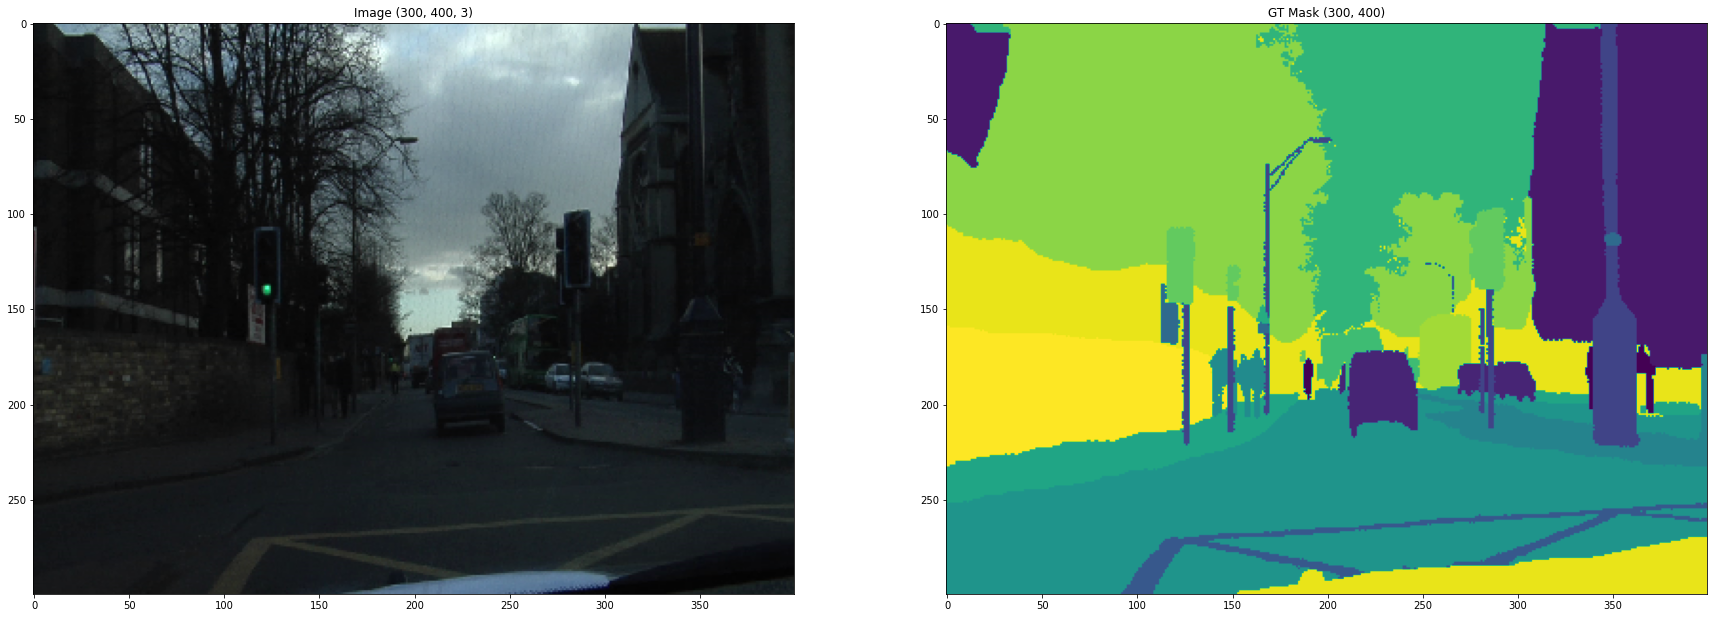

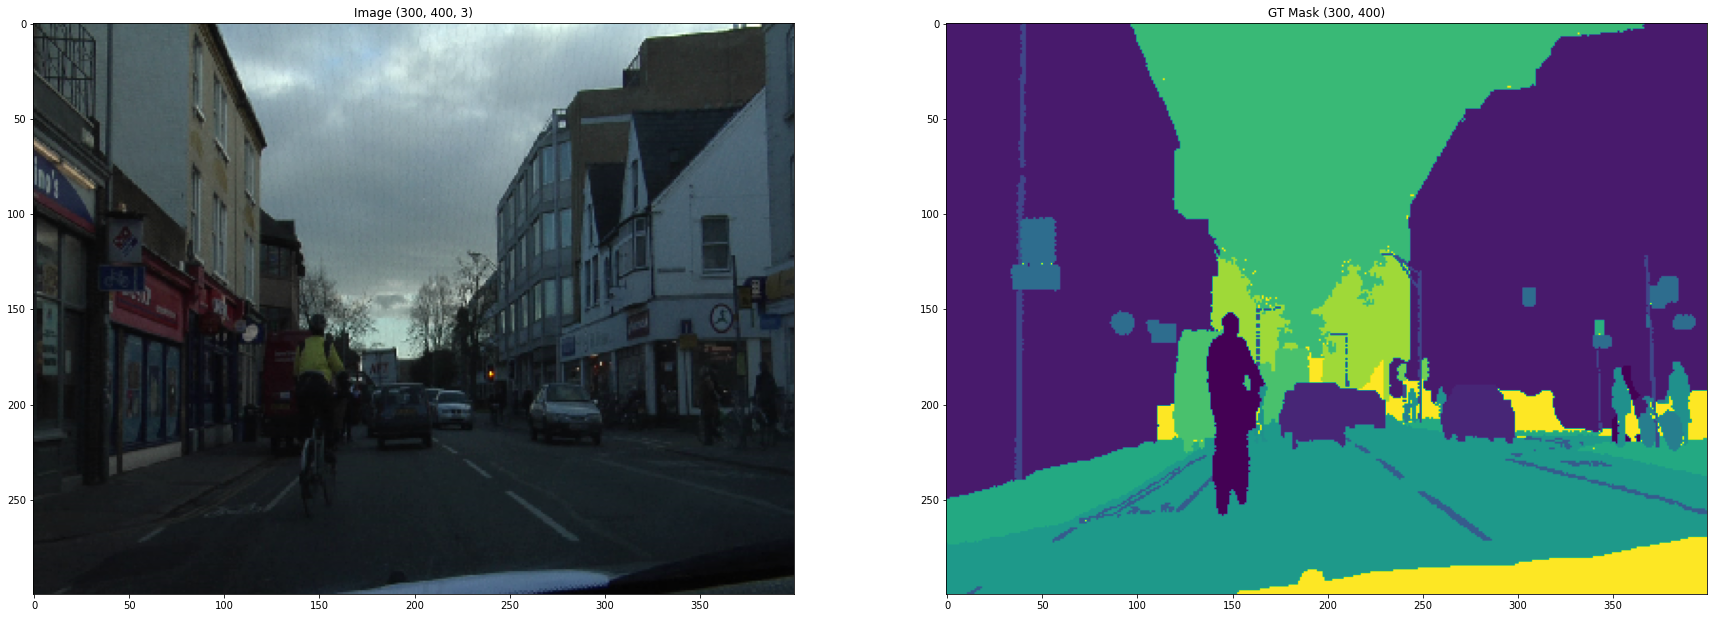

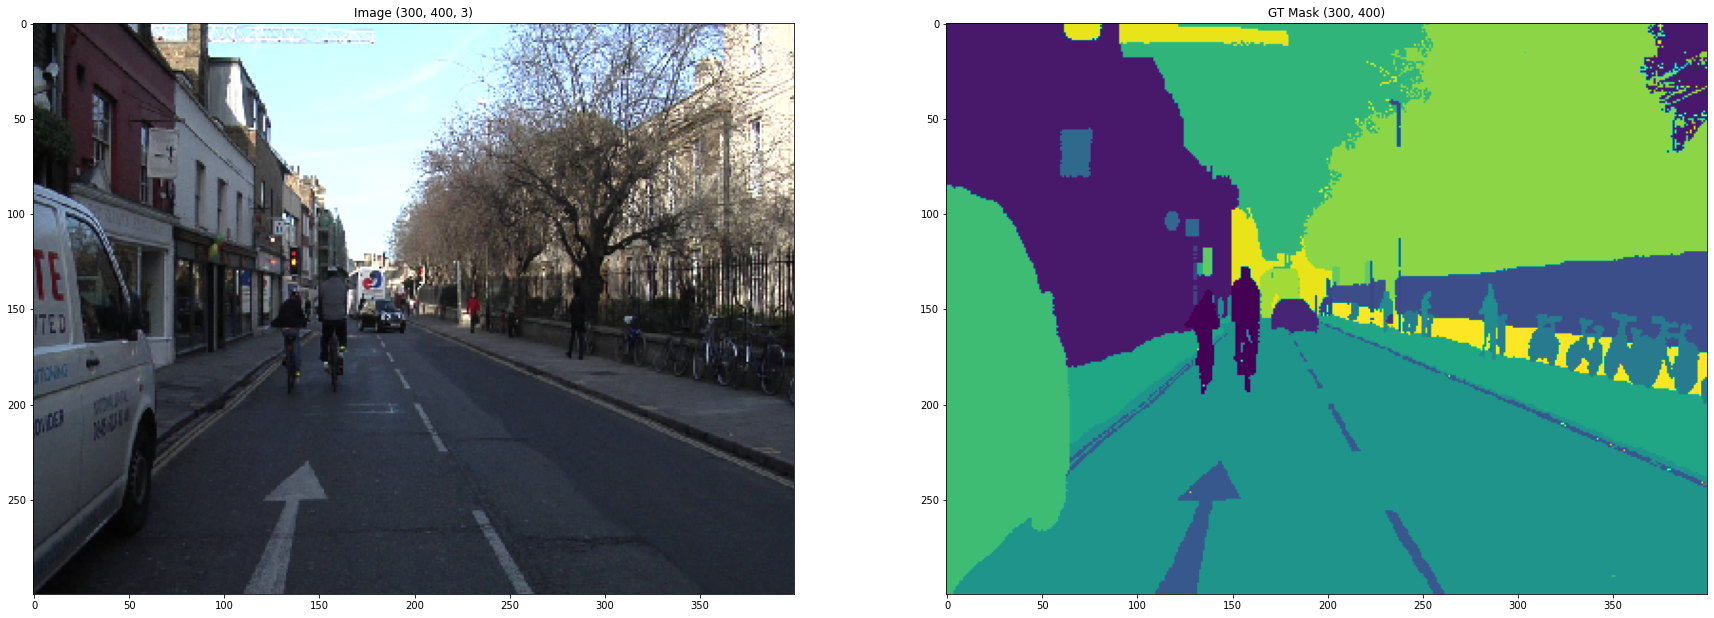

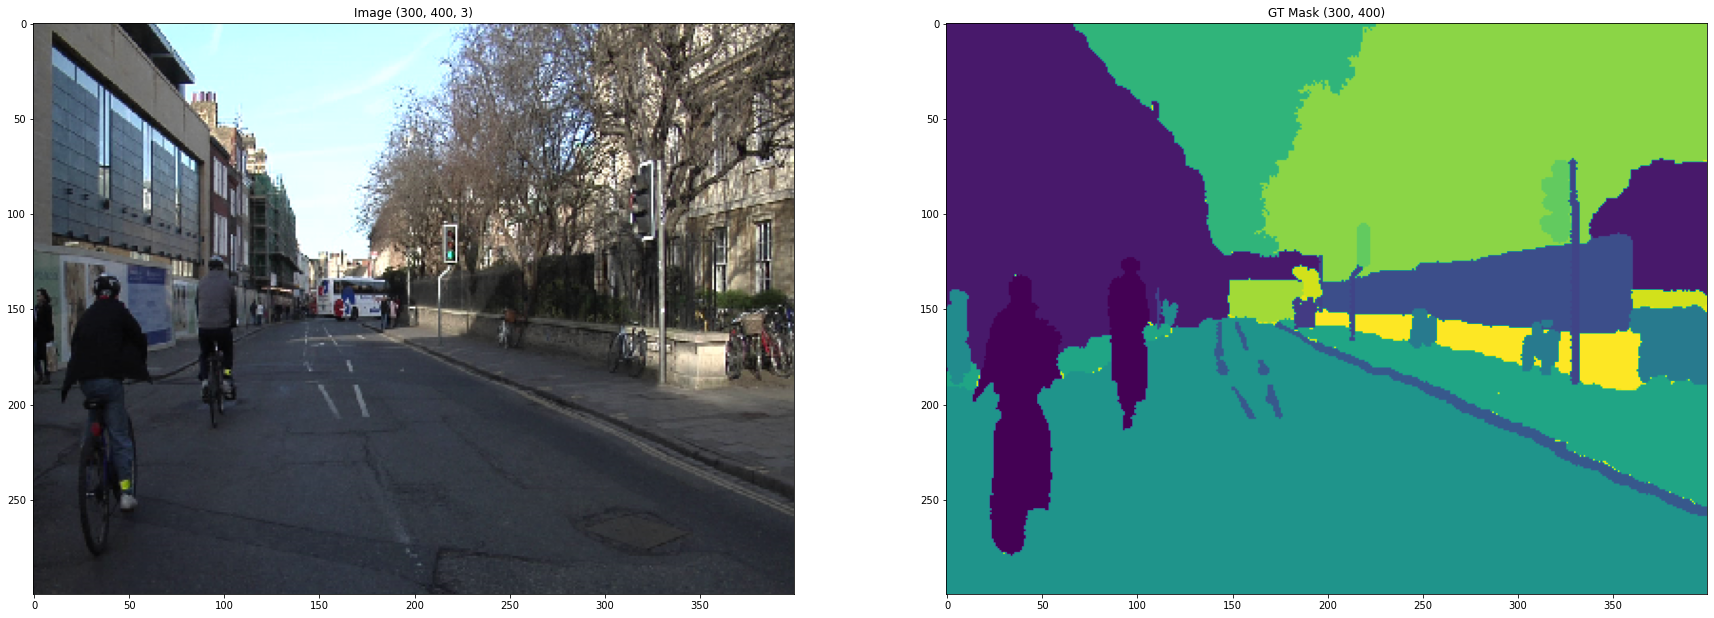

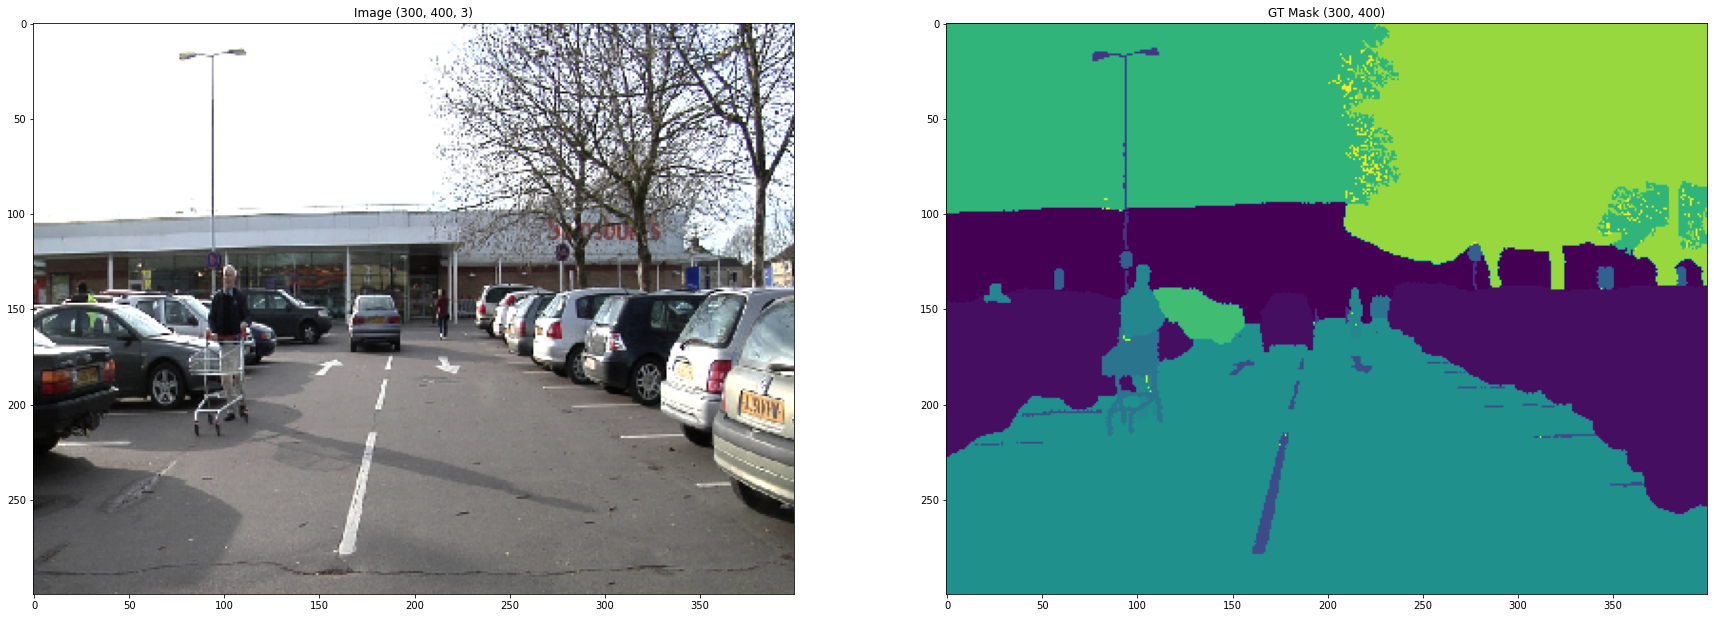

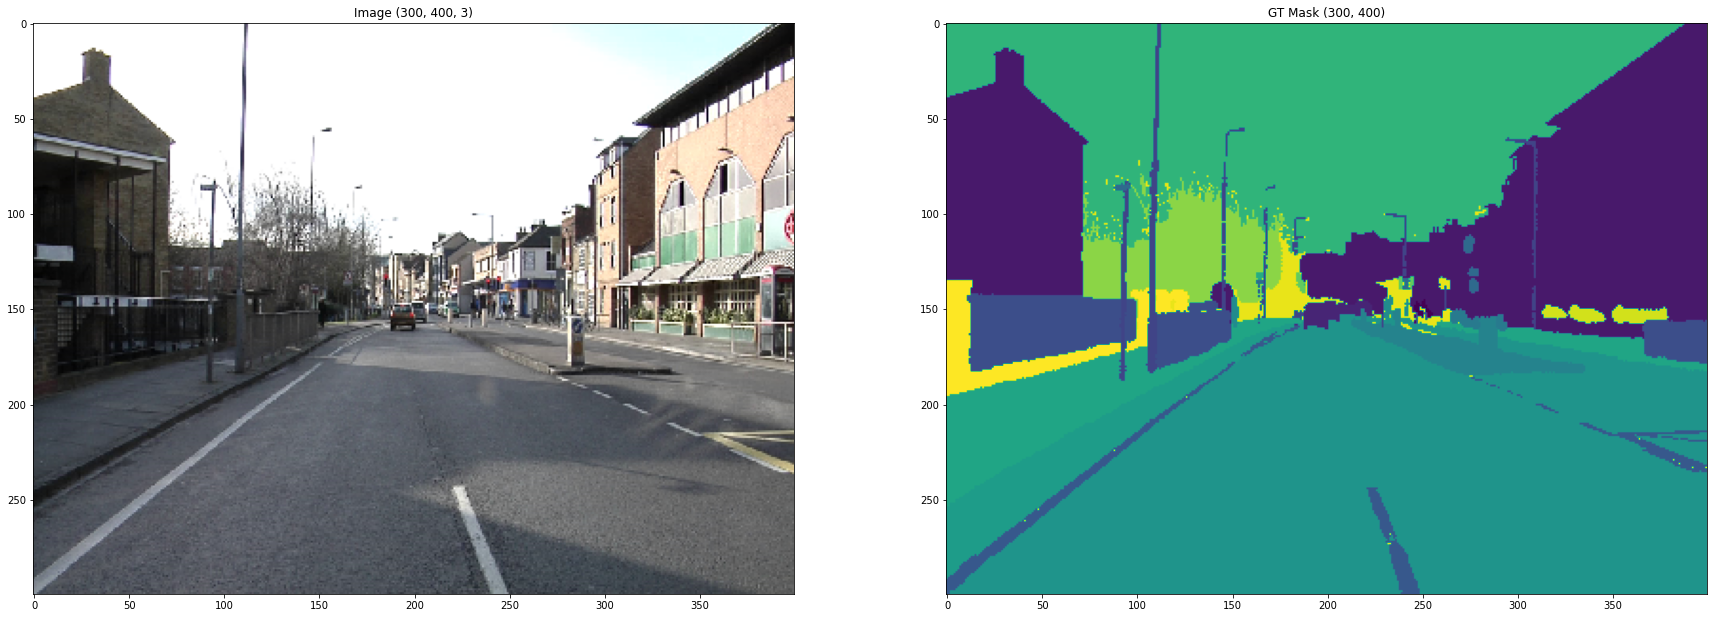

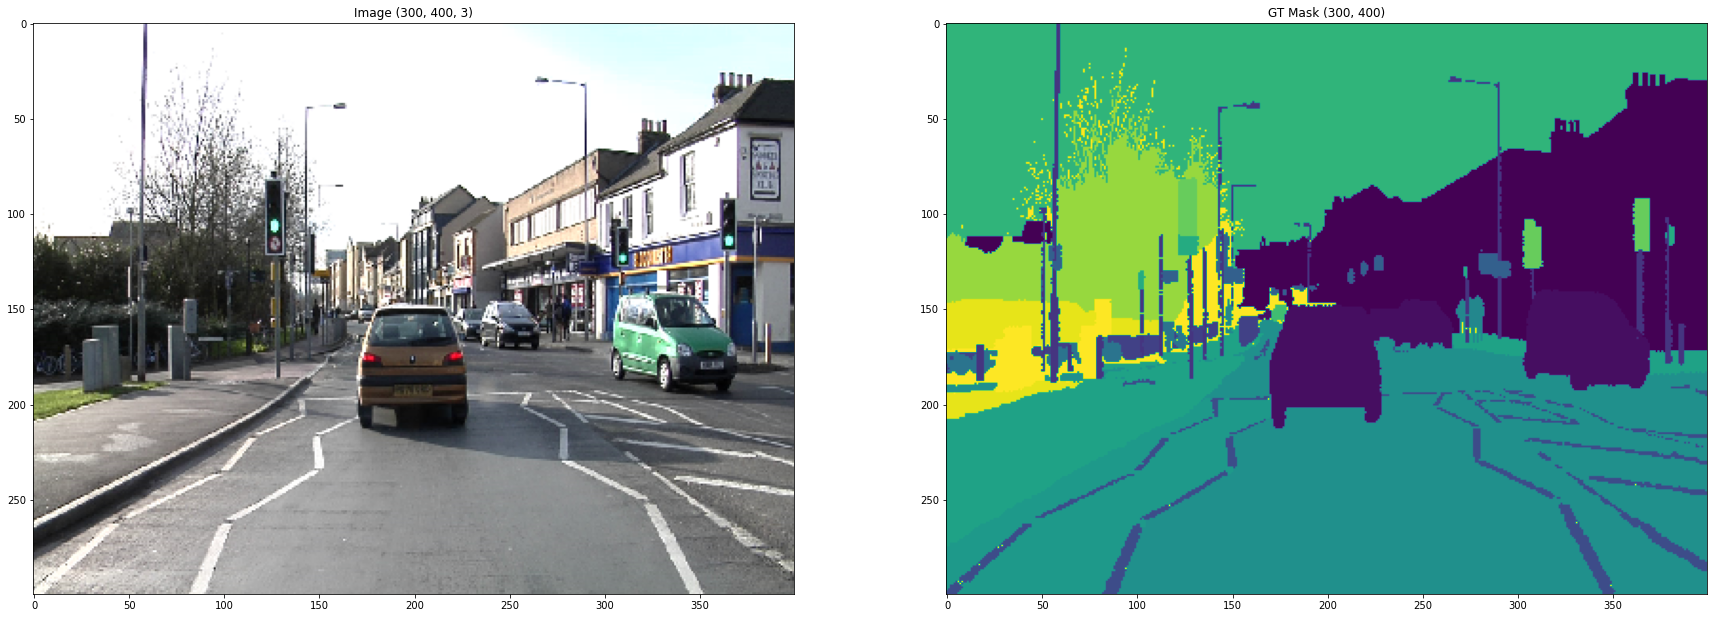

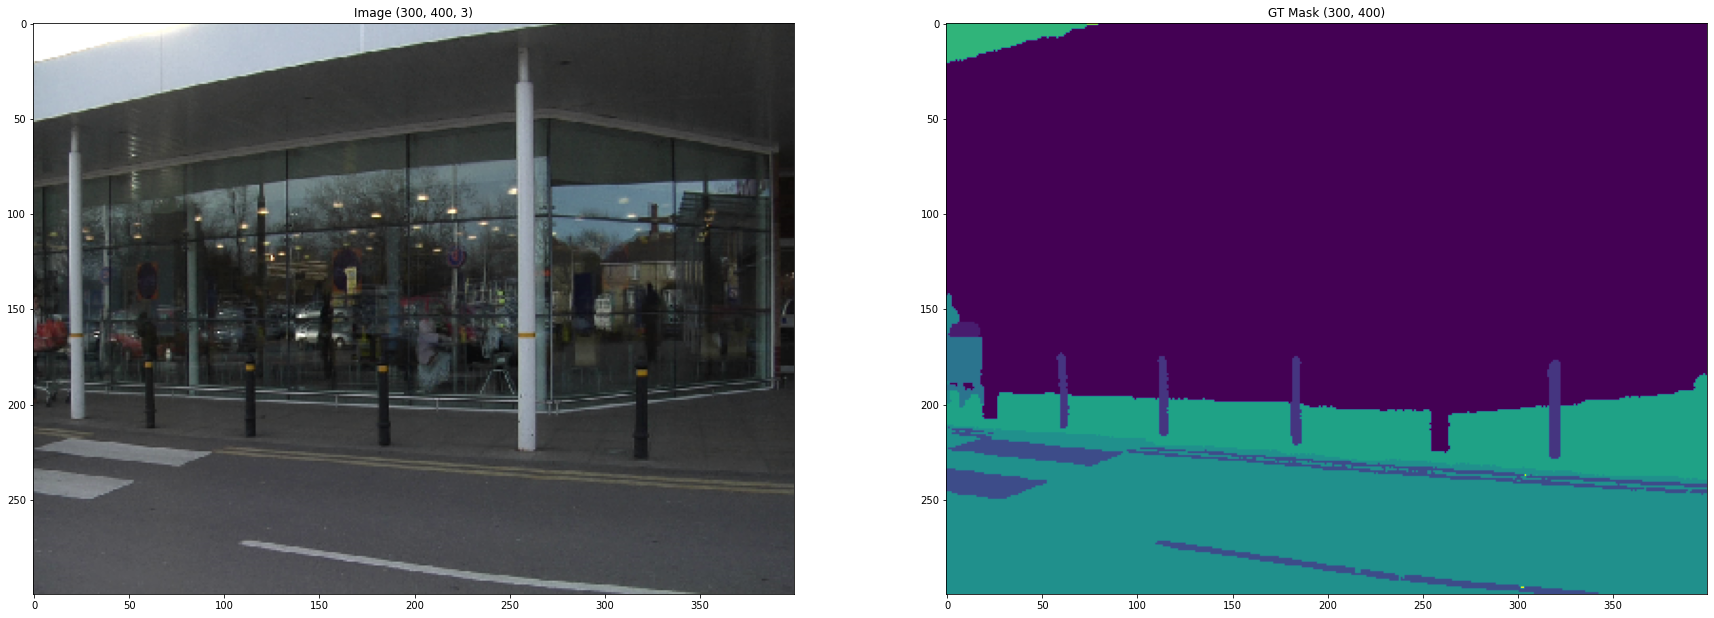

In [9]:


idx = np.random.randint(0, len(image_list), 10)
for i in idx:
    test = image.load_img(f'{image_dir}/{image_list[i]}', target_size=(300, 400))
    test_mask = image.load_img(f'{masks_dir}/'+f'{image_list[i][:-4]}'+"_P.png", target_size=(300, 400), grayscale=True)
    test = image.img_to_array(test).astype('uint8')
    test_mask = np.squeeze(image.img_to_array(test_mask)).astype('uint8')

    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(121)
    ax.set_title(f'Image {test.shape}')
    ax.imshow(test)

    ax2 = fig.add_subplot(122)
    ax2.set_title(f'GT Mask {test_mask.shape}')
    ax2.imshow(test_mask)

In [10]:
## Read class labels .txt file
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

In [11]:

# For each colour there is a particular class, there are 32 semantic classes

label_codes, label_names = zip(*[parse_code(l) for l in open("label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
print(len(label_codes))
label_codes[:5], label_names[:5]

32


([(64, 128, 64), (192, 0, 128), (0, 128, 192), (0, 128, 64), (128, 0, 0)],
 ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building'])

In [12]:
# Converting colour code to particular id
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}
print(id2code)

{0: (64, 128, 64), 1: (192, 0, 128), 2: (0, 128, 192), 3: (0, 128, 64), 4: (128, 0, 0), 5: (64, 0, 128), 6: (64, 0, 192), 7: (192, 128, 64), 8: (192, 192, 128), 9: (64, 64, 128), 10: (128, 0, 192), 11: (192, 0, 64), 12: (128, 128, 64), 13: (192, 0, 192), 14: (128, 64, 64), 15: (64, 192, 128), 16: (64, 64, 0), 17: (128, 64, 128), 18: (128, 128, 192), 19: (0, 0, 192), 20: (192, 128, 128), 21: (128, 128, 128), 22: (64, 128, 192), 23: (0, 0, 64), 24: (0, 64, 64), 25: (192, 64, 128), 26: (128, 128, 0), 27: (192, 128, 192), 28: (64, 0, 64), 29: (192, 192, 0), 30: (0, 0, 0), 31: (64, 192, 0)}


# Unet model

In [13]:
from tensorflow.keras import models,layers

In [14]:
input_layer = layers.Input(shape=(128,128,3),name='image_input')

# Encoder Segment
#block1
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block1 = layers.Activation("relu")(x)

#block2
x = layers.MaxPooling2D(pool_size=(2,2))(block1)
x = layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block2 = layers.Activation("relu")(x)

#block3
x = layers.MaxPooling2D(pool_size=(2,2))(block2)
x = layers.Conv2D(filters=256,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=256,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block3 = layers.Activation("relu")(x)


#block4
x = layers.MaxPooling2D(pool_size=(2,2))(block3)
x = layers.Conv2D(filters=512,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=512,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block4 = layers.Activation("relu")(x)
block4 = layers.Dropout(0.5)(block4)


#bottleneck
x = layers.MaxPooling2D(pool_size=(2,2))(block4)
x = layers.Conv2D(filters=1024,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=1024,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)

# Decoder segment
#block5
x = layers.Conv2DTranspose(filters=512,kernel_size=(3,3),padding='same',strides=(2,2))(x)
x = layers.concatenate([x,block4],axis=3)
x = layers.Conv2D(filters=512,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=512,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block5 = layers.Activation("relu")(x)

#block6
x = layers.Conv2DTranspose(filters=256,kernel_size=(3,3),padding='same',strides=(2,2))(block5)
x = layers.concatenate([x,block3],axis=3)
x = layers.Conv2D(filters=256,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=256,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block6 = layers.Activation("relu")(x)

#block7
x = layers.Conv2DTranspose(filters=128,kernel_size=(3,3),padding='same',strides=(2,2))(block6)
x = layers.concatenate([x,block2],axis=3)
x = layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block7 = layers.Activation("relu")(x)

#block8
x = layers.Conv2DTranspose(filters=64,kernel_size=(3,3),padding='same',strides=(2,2))(block7)
x = layers.concatenate([x,block1],axis=3)
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
x = layers.BatchNormalization()(x)
block8 = layers.Activation("relu")(x)

## outputlayer
output_layer = layers.Conv2D(filters=32,kernel_size=(1,1),activation='softmax')(block8)

model = models.Model(inputs=input_layer,outputs=output_layer)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

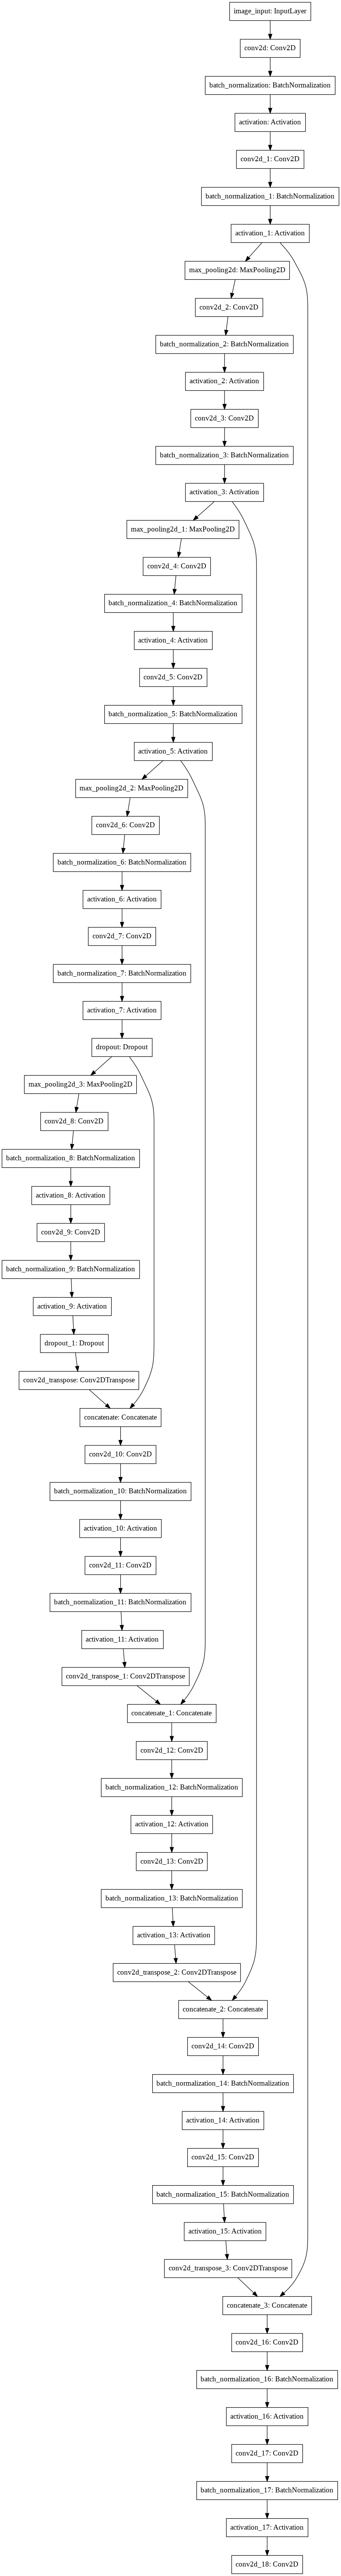

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [34]:
import tensorflow.keras.backend as b
from tensorflow.keras.metrics import MeanIoU
import tensorflow as tf

In [50]:
def accuracy_metric(ytest,ypred):
  ypred = b.argmax(ypred)
  ypred = tf.dtypes.cast(ypred,tf.float32)
  return b.mean(ytest==ypred)


model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [51]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback

samples = len(mask_list)
img_height,img_width=128,128
batch_size=10
class seg_gen(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idx = np.random.randint(0, samples, batch_size)
        batch_x, batch_y = [], []
        drawn = 0
        for i in idx:
            _image = image.img_to_array(image.load_img(f'{image_dir}/{image_list[i]}', target_size=(img_height, img_width)))/255.   
            mask = image.img_to_array(image.load_img(f'{masks_dir}/'+f'{image_list[i][:-4]}'+"_P.png", grayscale=True, target_size=(img_height, img_width)))
#             mask = np.resize(mask,(img_height*img_width, classes))
            batch_y.append(mask)
            batch_x.append(_image)
        return np.array(batch_x), np.array(batch_y)

In [52]:
train_gen = seg_gen(image_list,mask_list,10)
model.fit_generator(train_gen,epochs=20,verbose=True)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Epoch 1/20
71/71 [==============================] - 24s 333ms/step - loss: 0.6012 - sparse_categorical_accuracy: 0.8263
Epoch 2/20
71/71 [==============================] - 23s 327ms/step - loss: 0.5362 - sparse_categorical_accuracy: 0.8450
Epoch 3/20
71/71 [==============================] - 23s 327ms/step - loss: 0.5572 - sparse_categorical_accuracy: 0.8370
Epoch 4/20
71/71 [==============================] - 24s 331ms/step - loss: 0.5128 - sparse_categorical_accuracy: 0.8484
Epoch 5/20
71/71 [==============================] - 23s 326ms/step - loss: 0.4863 - sparse_categorical_accuracy: 0.8549
Epoch 6/20
71/71 [==============================] - 23s 328ms/step - loss: 0.4597 - sparse_categorical_accuracy: 0.8626
Epoch 7/20
71/71 [==============================] - 23s 329ms/step - loss: 0.4692 - sparse_categorical_accuracy: 0.8595
Epoch 8/20
71/71 [==============================] - 23s 329ms/step - loss: 0.4586 - sparse_categorical_accuracy: 0.8620
Epoch 9/20
71/71 [======================

In [53]:
!wget -q https://raw.githubusercontent.com/anshupandey/Computer-Vision/master/Image%20Segmentation/test_images.zip

In [54]:
!unzip test_images.zip

Archive:  test_images.zip
  inflating: test_images/0016E5_07981.png  
  inflating: test_images/0016E5_08003.png  


In [55]:

test_dir = 'test_images/'
image_list = os.listdir(test_dir)
print(f'{len(image_list)} frames found')

2 frames found


In [56]:
# Assign different objects with colurs with the help of id2code
def color_label(a): 
    print(a.shape)
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            var = id2code[a[j,k]]
            res[j,k] = var
    return res

(360, 480)


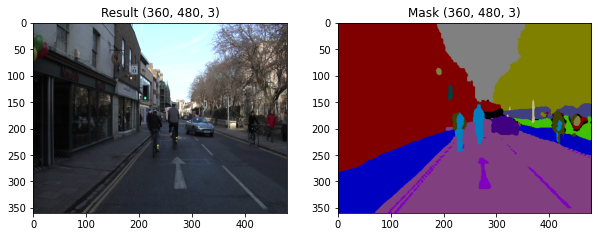

In [58]:
test = image.load_img('test_images/0016E5_08003.png')
imh = image.img_to_array(test)
dims = imh.shape
x = cv2.resize(imh, (128, 128))
x = np.float32(x)/255.
##########get the predictions
z = model.predict(np.expand_dims(x, axis=0))

z = np.squeeze(z)
z = cv2.resize(z, (dims[1], dims[0]))
y = np.argmax(z, axis=2)
vb= color_label(y)

fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(121)
ax.set_title(f'Result {imh.shape}')
ax.imshow(np.uint8(imh))

ax2 = fig.add_subplot(122)
ax2.set_title(f'Mask {vb.shape}')
ax2.imshow(vb)